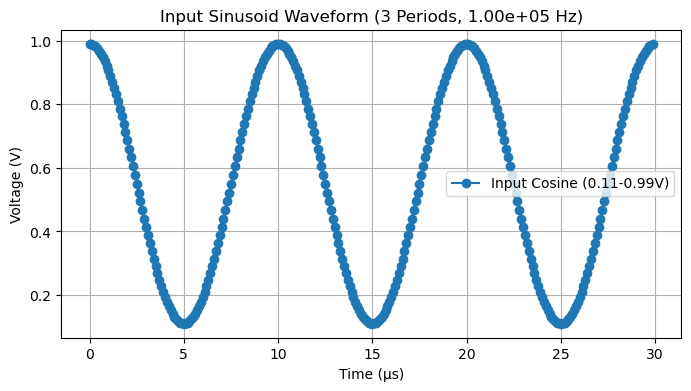

num_samples = 300


In [9]:
# Cell 1: Imports, Parameters, and Input Signal Generation

import numpy as np
import matplotlib.pyplot as plt

# ADC Parameters
Vdd = 1.1             # Supply voltage (V)
Vref = Vdd            # Reference voltage for DAC
fs = 10e6             # Sampling frequency of T/H Circuit (10 MS/s)
ts = 1/fs             # Sampling period = 100ns
nbits = 12            # ADC resolution (bits)

# Input Sinusoid Parameters
f_in = 1e5           # Input cosine frequency
num_periods = 3       # Simulation Length in terms of Sinusoidal Periods
num_samples = int((fs/f_in) * num_periods)    # Number of Samples per Period
t_total = num_samples * ts  # Total simulation time

# Generate time vector for the sampled input signal
t_samples = np.linspace(0, t_total, num_samples, endpoint=False)

# Generate input cosine waveform
# (cosine oscillates between -1 and 1; we shift to Vdd/2 and scale to %_of_Vdd)
# Vin = Vdd/2 * %_of_Vdd * Cosine + Vdd/2
Vin = Vdd/2 * .8 * np.cos(2 * np.pi * f_in * t_samples) + Vdd/2


# Plot the input waveform (sampled values)
plt.figure(figsize=(8, 4))
plt.plot(t_samples*1e6, Vin, 'o-', label=f"Input Cosine ({min(Vin):.2f}-{max(Vin):.2f}V)")
plt.xlabel('Time (µs)')
plt.ylabel('Voltage (V)')
plt.title(f"Input Sinusoid Waveform ({num_periods} Periods, {f_in:.2e} Hz)")
plt.grid(True)
plt.legend()
plt.show()
print(f"num_samples = {num_samples}")

In [2]:

# Cell 2: T/H Circuit with Non-Idealities
# The T/H circuit will "track" the input and then "hold" the value over nbits SAR cycles.
# Non-idealities include:
#   - Noise (Gaussian, with specified standard deviation)
#   - Pedestal error (a constant offset)
#   - Droop (linear decay during hold)

def track_hold(sample_value, noise_std=0.0, pedestal=0.0, droop_rate=0.0, num_cycles=nbits, sar_clock_period=1/(nbits * fs)):
    """
    Simulate a Track/Hold circuit with non-idealities.
    
    Parameters:
      sample_value   : The input analog voltage to be sampled.
      noise_std      : Standard deviation of additive Gaussian noise.
      pedestal       : Constant voltage offset.
      droop_rate     : Voltage droop rate (V/s) during hold.
      num_cycles     : Number of SAR cycles the value is held.
      sar_clock_period: Time per SAR cycle.
      
    Returns:
      th_values: A numpy array of length num_cycles containing the held (and decayed) voltage.
    """
    # Sample the value and add pedestal and noise (applied at t=0)
    initial_value = sample_value + pedestal + np.random.normal(0, noise_std)
    
    # Generate an array for the held value for each SAR cycle accounting for droop
    th_values = np.array([initial_value - droop_rate * (i * sar_clock_period) for i in range(num_cycles)])
    return th_values

# Example usage: simulate a T/H output for a sample value of 0.7V with all non-idealities off.
#example_th = track_hold(0.7, noise_std=0.0, pedestal=0.0, droop_rate=0.0)
#print("Example T/H output (ideal):", example_th)

In [3]:
# Cell 3: DAC Function with Non-Idealities
# The DAC converts a binary code to an analog voltage using Vref.
# Non-idealities include:
#   - Differential Non-Linearity (DNL)
#   - Integral Non-Linearity (INL)
#   - Gain Error
#   - Offset Error
#   - Glitch Energy
#   - Settling Time Error

def dac_convert(code, Vref=Vref, nbits=nbits,
                dnl=0.0, inl=0.0, gain_error=0.0, offset_error=0.0,
                glitch_energy=0.0, settling_time_error=0.0):
    """
    Convert a digital code to an analog voltage using a DAC with potential non-idealities.
    
    Parameters:
      code             : The digital code (integer).
      Vref             : Reference voltage.
      nbits            : Number of bits.
      dnl, inl         : Differential and integral non-linearity errors.
      gain_error       : Proportional gain error (fractional).
      offset_error     : Constant voltage offset error.
      glitch_energy    : Transient error during code transitions.
      settling_time_error: Error due to incomplete settling.
      
    Returns:
      analog_voltage   : The DAC output voltage.
    """
    # Ideal DAC conversion
    ideal = (code / (2**nbits - 1)) * Vref
    
    # Apply non-idealities (currently set to zero for an ideal DAC)
    analog_voltage = ideal * (1 + gain_error) + offset_error + inl + dnl + glitch_energy + settling_time_error
    return analog_voltage

# Example usage: Convert code 2048 with ideal parameters
#print("DAC output for code 2048 (ideal):", dac_convert(2048))

In [4]:
# Cell 4: Comparator Function with Non-Idealities
# The comparator compares the T/H value and the DAC output.
# It includes parameters for offset, noise, and delay (for future expansion).
# For now, all non-idealities are set to zero.

def comparator(th_value, dac_value, offset=0.0, noise_std=0.0, delay=0.0):
    """
    Compare the T/H voltage and the DAC output.
    
    Parameters:
      th_value : Voltage from the T/H circuit.
      dac_value: Voltage from the DAC.
      offset   : Comparator offset error.
      noise_std: Comparator noise standard deviation.
      delay    : Comparator delay (not used in this abstract model).
      
    Returns:
      comp_out : 1 if th_value (with errors) >= dac_value, else 0.
    """
    # Add offset and noise to the T/H value for comparison
    comp_input = th_value + offset + np.random.normal(0, noise_std)
    return 1 if comp_input >= dac_value else 0

# Example usage: Compare 0.5V T/H value and 0.5V DAC output (ideal comparator)
#print("Comparator output (ideal) for 0.5V vs 0.5V:", comparator(0.5, 0.5))

In [5]:
# Cell 5: Simplified SAR ADC Control Logic (Independent Conversion)
# This version resets the SAR register to mid-scale (~Vref/2 equivalent) for every new sample.
# It performs a single pass over the bit positions from MSB to LSB.

def sar_conversion(th_values, Vref=Vref, nbits=nbits,
                   dac_params=None, comparator_params=None, initial_code=None):
    """
    Perform SAR conversion using held T/H values over one pass (from MSB to LSB),
    with the SAR register reinitialized to mid-scale for every sample.
    
    Parameters:
      th_values         : Array of T/H values (one per SAR cycle) for the current sample.
      Vref              : DAC reference voltage.
      nbits             : Number of bits.
      dac_params        : Dictionary of DAC non-ideality parameters.
      comparator_params : Dictionary of comparator non-ideality parameters.
      
    Returns:
      result            : Dictionary containing:
                          - final_code: The final digital code after SAR conversion.
                          - dac_outputs: List of DAC outputs at each SAR cycle.
                          - comp_outputs: List of comparator outputs at each cycle.
                          - sar_register_history: List of the SAR register value after each cycle.
    """
    if dac_params is None:
        dac_params = {'dnl': 0.0, 'inl': 0.0, 'gain_error': 0.0,
                      'offset_error': 0.0, 'glitch_energy': 0.0,
                      'settling_time_error': 0.0}
    if comparator_params is None:
        comparator_params = {'offset': 0.0, 'noise_std': 0.0, 'delay': 0.0}
    
    # Reinitialize SAR register to mid-scale (digital code corresponding to ~Vref/2)
    initial_code = int(round((0.5) * (2**nbits - 1)))
    sar_reg = initial_code
    dac_outputs = []
    comp_outputs = []
    sar_history = []
    
    # Iterate from MSB to LSB (bit positions: nbits-1 down to 0)
    for bit in range(nbits-1, -1, -1):
        # Tentatively set the current bit to 1
        tentative_code = sar_reg | (1 << bit)
        # Convert tentative code to analog using DAC
        dac_out = dac_convert(tentative_code, Vref=Vref, nbits=nbits, **dac_params)
        dac_outputs.append(dac_out)
        
        # Get comparator output (using the corresponding T/H value)
        comp_out = comparator(th_values[nbits-1-bit], dac_out, **comparator_params)
        comp_outputs.append(comp_out)
        
        # Update SAR register:
        # If comparator returns 1, keep the bit; if 0, clear that bit.
        if comp_out == 1:
            sar_reg = tentative_code
        else:
            sar_reg = sar_reg & ~(1 << bit)
        
        sar_history.append(sar_reg)
    
    return {'final_code': sar_reg,
            'dac_outputs': dac_outputs,
            'comp_outputs': comp_outputs,
            'sar_register_history': sar_history}

# Example usage:
# For an ideal T/H value array corresponding to a sample of 0.7V,
# the SAR conversion will always start from mid-scale (0.55V equivalent).
#example_th_values = track_hold(0.7, noise_std=0.0, pedestal=0.0, droop_rate=0.0,
#                               num_cycles=nbits, sar_clock_period=1/(nbits * fs))
#sar_result_example = sar_conversion(example_th_values)
#print("Example SAR conversion result (independent conversion, ideal):", sar_result_example)

In [6]:
# Cell 6: Integration – Simulate the ADC conversion for all samples with Previous Final Code Tracking

# Dictionaries to hold non-ideality parameters (set to zero for an ideal model)
th_nonideal_params = {'noise_std': 0.0, 'pedestal': 0.0, 'droop_rate': 0.0}
dac_nonideal_params = {'dnl': 0.0, 'inl': 0.0, 'gain_error': 0.0, 
                       'offset_error': 0.0, 'glitch_energy': 0.0, 
                       'settling_time_error': 0.0}
comparator_nonideal_params = {'offset': 0.0, 'noise_std': 0.0, 'delay': 0.0}

# SAR clock period (for 120 MHz clock)
sar_clock_period = 1/(nbits * fs)

# Lists to store the simulation outputs
all_final_codes = []
all_reconstructed = []  # Reconstructed analog voltages from final codes
all_th_values = []      # T/H values (each sample yields an array of 12 values)
all_dac_outputs = []    # DAC outputs for each SAR cycle (per sample)
all_comp_outputs = []   # Comparator outputs (per sample)
all_sar_history = []    # SAR register evolution for each sample

prev_final_code = None  # For the first sample, prev_final_code is None (default will be used)

# Iterate over each sample in the input signal
for sample in Vin:
    # Get T/H held values for current sample with non-idealities
    th_values = track_hold(sample, **th_nonideal_params, num_cycles=nbits, sar_clock_period=sar_clock_period)
    all_th_values.append(th_values)
    
    # Perform SAR conversion for the held sample,
    # passing the previous final code as the initial value for this conversion.
    sar_result = sar_conversion(th_values, Vref=Vref, nbits=nbits,
                                dac_params=dac_nonideal_params, 
                                comparator_params=comparator_nonideal_params,
                                initial_code=prev_final_code)
    
    # Save the outputs from this conversion
    all_final_codes.append(sar_result['final_code'])
    all_dac_outputs.append(sar_result['dac_outputs'])
    all_comp_outputs.append(sar_result['comp_outputs'])
    all_sar_history.append(sar_result['sar_register_history'])
    
    # Reconstruct the analog value from the final digital code
    analog_out = dac_convert(sar_result['final_code'], Vref=Vref, nbits=nbits, **dac_nonideal_params)
    all_reconstructed.append(analog_out)
    
    # Update prev_final_code for the next sample
    prev_final_code = sar_result['final_code']

# Convert lists to numpy arrays for further analysis if needed
all_final_codes = np.array(all_final_codes)
all_reconstructed = np.array(all_reconstructed)
all_th_values = np.array(all_th_values)  # Shape: (num_samples, nbits)

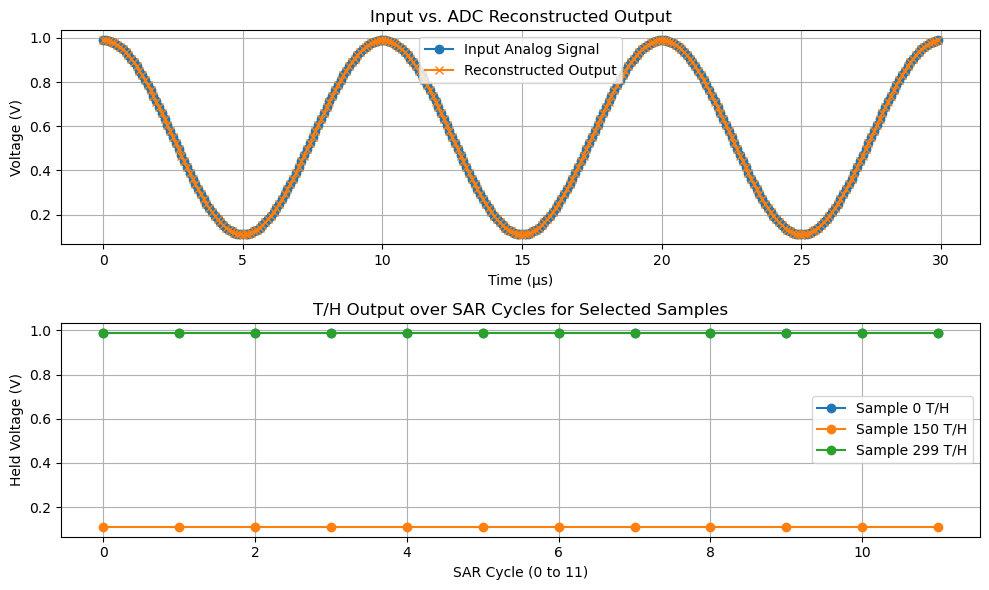

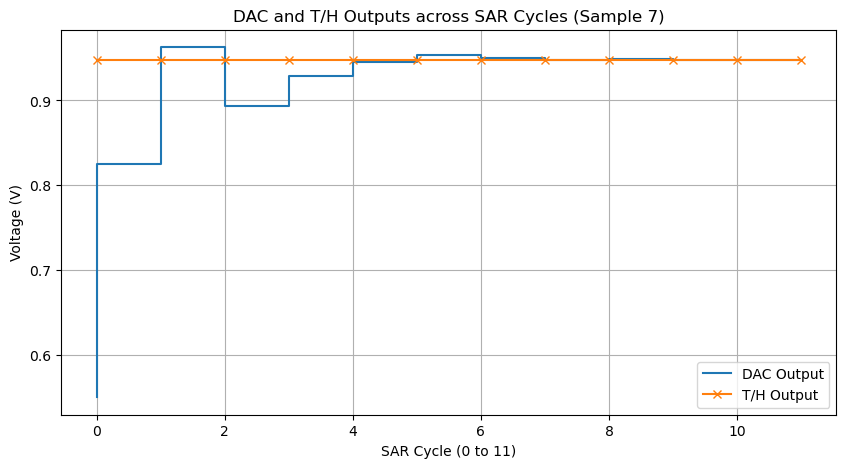

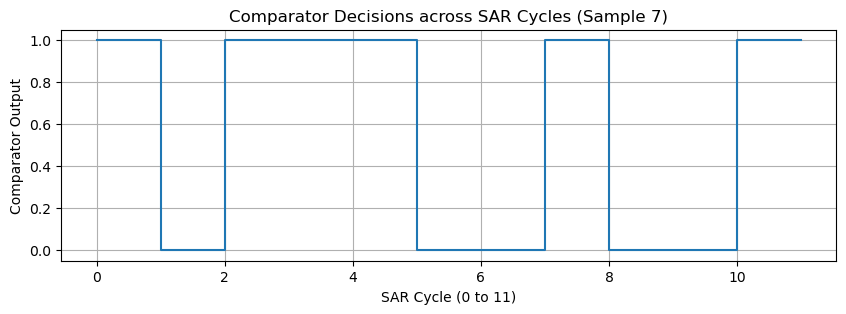

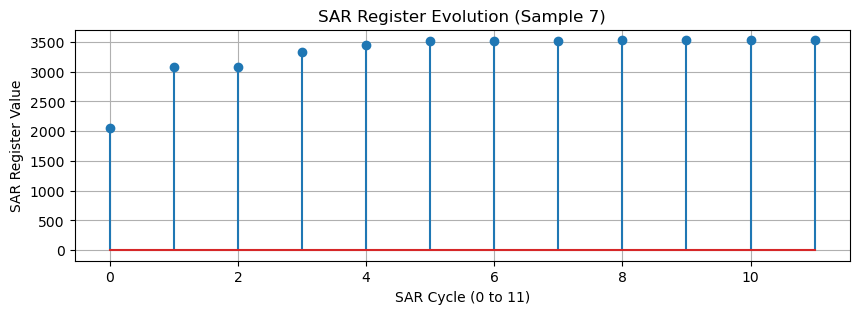

In [7]:
# Cell 7: Plot Intermediate Signals and Compare Input vs. ADC Output

# Plot the original input samples and the reconstructed output (from final digital code)
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(t_samples*1e6, Vin, 'o-', label='Input Analog Signal')
plt.plot(t_samples*1e6, all_reconstructed, 'x-', label='Reconstructed Output')
plt.xlabel('Time (µs)')
plt.ylabel('Voltage (V)')
plt.title('Input vs. ADC Reconstructed Output')
plt.legend()
plt.grid(True)

# Plot T/H held values for a few selected samples (for clarity, choose 3 samples)
sample_indices = [0, num_samples//2, num_samples-1]
plt.subplot(2,1,2)
for idx in sample_indices:
    cycles = np.arange(nbits)
    plt.plot(cycles, all_th_values[idx], marker='o', label=f'Sample {idx} T/H')
plt.xlabel('SAR Cycle (0 to 11)')
plt.ylabel('Held Voltage (V)')
plt.title('T/H Output over SAR Cycles for Selected Samples')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# For a single sample, also plot the DAC outputs and comparator decisions across SAR cycles
sample_to_inspect = 7  # Inspect the first sample
cycles = np.arange(nbits)

plt.figure(figsize=(10, 5))
plt.step(cycles, all_dac_outputs[sample_to_inspect], label='DAC Output')
plt.step(cycles, all_th_values[sample_to_inspect], marker='x', label='T/H Output')
plt.xlabel('SAR Cycle (0 to 11)')
plt.ylabel('Voltage (V)')
plt.title(f'DAC and T/H Outputs across SAR Cycles (Sample {sample_to_inspect})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.step(cycles, all_comp_outputs[sample_to_inspect])
plt.xlabel('SAR Cycle (0 to 11)')
plt.ylabel('Comparator Output')
plt.title(f'Comparator Decisions across SAR Cycles (Sample {sample_to_inspect})')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.stem(cycles, all_sar_history[sample_to_inspect])
plt.xlabel('SAR Cycle (0 to 11)')
plt.ylabel('SAR Register Value')
plt.title(f'SAR Register Evolution (Sample {sample_to_inspect})')
plt.grid(True)
plt.show()

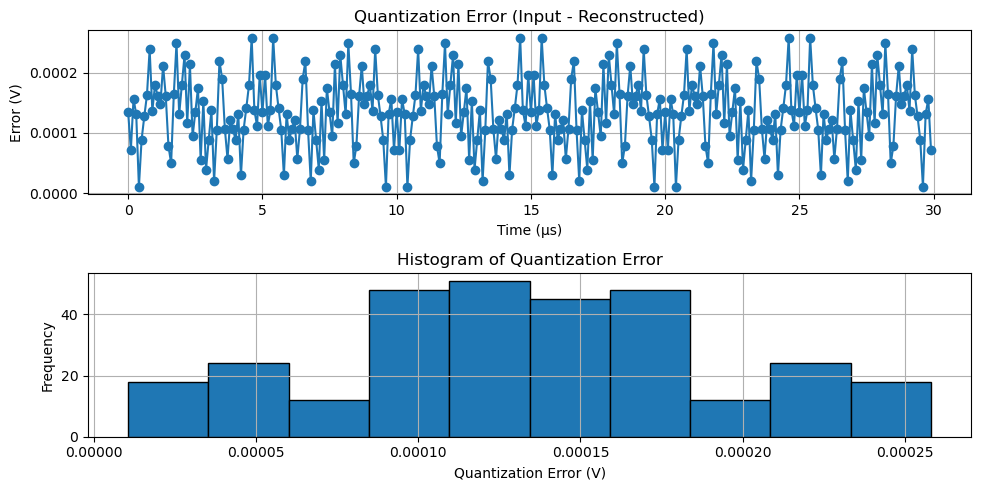

Quantization Error Statistics:
Mean error: 0.00013431013431005858
Std deviation: 5.9039154325984075e-05
Max error: 0.0002580855380790309
Min error: 1.0534730541245096e-05


In [8]:
# Cell 8: Additional Analysis – Quantization Error and Histogram

# Compute quantization error for each sample
quantization_error = Vin - all_reconstructed

plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(t_samples*1e6, quantization_error, 'o-')
plt.xlabel('Time (µs)')
plt.ylabel('Error (V)')
plt.title('Quantization Error (Input - Reconstructed)')
plt.grid(True)

plt.subplot(2,1,2)
plt.hist(quantization_error, bins=10, edgecolor='k')
plt.xlabel('Quantization Error (V)')
plt.ylabel('Frequency')
plt.title('Histogram of Quantization Error')
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional analysis: Print out basic statistics of the quantization error
print("Quantization Error Statistics:")
print("Mean error:", np.mean(quantization_error))
print("Std deviation:", np.std(quantization_error))
print("Max error:", np.max(quantization_error))
print("Min error:", np.min(quantization_error))